[{'value': 30, 'value_classification': 'Fear', 'timestamp': '1517461200', 'time': '2018-02-01'}, {'value': 15, 'value_classification': 'Extreme Fear', 'timestamp': '1517547600', 'time': '2018-02-02'}, {'value': 40, 'value_classification': 'Fear', 'timestamp': '1517634000', 'time': '2018-02-03'}, {'value': 24, 'value_classification': 'Fear', 'timestamp': '1517720400', 'time': '2018-02-04'}, {'value': 11, 'value_classification': 'Extreme Fear', 'timestamp': '1517806800', 'time': '2018-02-05'}, {'value': 8, 'value_classification': 'Extreme Fear', 'timestamp': '1517893200', 'time': '2018-02-06'}, {'value': 36, 'value_classification': 'Fear', 'timestamp': '1517979600', 'time': '2018-02-07'}, {'value': 30, 'value_classification': 'Fear', 'timestamp': '1518066000', 'time': '2018-02-08'}, {'value': 44, 'value_classification': 'Fear', 'timestamp': '1518152400', 'time': '2018-02-09'}, {'value': 54, 'value_classification': 'Neutral', 'timestamp': '1518238800', 'time': '2018-02-10'}, {'value': 31,

         time      close
0  2018-02-01  9222.2920
1  2018-02-02  8893.7700
2  2018-02-03  9092.1304
3  2018-02-04  8198.9811
4  2018-02-05  6959.4452
         time  value value_classification      close
0  2018-02-01     30                 Fear  9222.2920
1  2018-02-02     15         Extreme Fear  8893.7700
2  2018-02-03     40                 Fear  9092.1304
3  2018-02-04     24                 Fear  8198.9811
4  2018-02-05     11         Extreme Fear  6959.4452


ploting


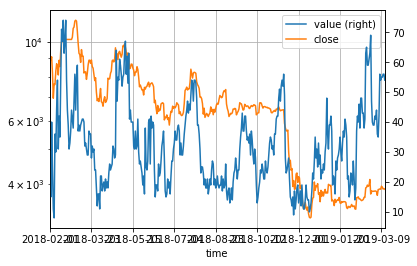

In [1]:
import requests
import time
import pandas as pd
from matplotlib import pyplot as plt

ot_key = ''

def get_candles(contract='okex/btc.usdt', since = '2018-02-01', until = None, duration = '1d'):
    if (until == None):
        time_local = time.localtime()
        until = time.strftime( "%Y-%m-%d", time_local )

    url = 'http://hist-quote.1tokentrade.cn/candles?since={}&until={}&contract={}&duration={}&format=json'.format(
        since, until, contract, duration )

    r = requests.get( url, headers={'ot-key': ot_key} )

    if r.status_code != 200:
        print( 'fail get candles', r.status_code, r.text )
        return
    r = r.json()

    for i in range( len( r ) ):
        time_local = time.localtime( r[i]['timestamp'] )
        time_str = time.strftime( "%Y-%m-%d", time_local )
        r[i]['time'] = time_str

    return r


def get_fear_greed_index(limit = 0):
    url = 'https://api.alternative.me/fng/?limit={}'.format(limit)
    #print(url)
    r = requests.get(url)

    if r.status_code != 200:
        print( 'fail get fear_greed_index', r.status_code, r.text )
        return
    r = r.json()['data']

    for i in range( len( r ) ):
        times_tamp = int( r[i]['timestamp'] )
        time_local = time.localtime( times_tamp )
        time_str = time.strftime( "%Y-%m-%d", time_local )
        r[i]['time'] = time_str
        r[i]['value'] = int( r[i]['value'] )

    return r


fgi = get_fear_greed_index()[::-1]
print(fgi)

fgi_df = pd.DataFrame(fgi,columns=['time','value','value_classification'])
print(fgi_df.head())

candle = get_candles()
candle_df = pd.DataFrame(candle,columns=['time','close'])
print(candle_df.head())

res = pd.merge(fgi_df,candle_df)
print(res.head())

res.plot(x = 'time',y = ['value','close'],\
         secondary_y=['value'], logy=True,grid = True)
print('ploting')
plt.show()
print('plot done')

In [ ]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])


# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
        ('printlog', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.optstrategy(
        TestStrategy,
        maperiod=range(10, 31))

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, '../../datas/orcl-1995-2014.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2000, 12, 31),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Run over everything
    cerebro.run()
